# 1. Load Data

In [0]:
# mount google drive to store files for reproducibility
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# imports 
import ast
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image, ImageDraw
from skimage import filters, feature
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization

In [0]:
# get data - you can add more classes here
df = pd.read_csv('/content/drive/My Drive/Quickdraw/penis-simplified.csv')
df2 = pd.read_csv('/content/drive/My Drive/Quickdraw/airplane.csv')
df3 = pd.read_csv('/content/drive/My Drive/Quickdraw/arm.csv')
# df4 = pd.read_csv('Quickdraw/asparagus.csv')
# df5 = pd.read_csv('Quickdraw/anvil.csv')
# df6 = pd.read_csv('Quickdraw/ant.csv')
# df7 = pd.read_csv('Quickdraw/animal migration.csv')
# df8 = pd.read_csv('Quickdraw/angel.csv')
# df9 = pd.read_csv('Quickdraw/alarm clock.csv')
# df10 = pd.read_csv('Quickdraw/ambulance.csv')
# df11 = pd.read_csv('Quickdraw/apple.csv')


# removing images not recognized
df2 = df2[df2['recognized'] == True]
df3 = df3[df3['recognized'] == True]
# df4 = df4[df4['recognized'] == True]
# df5 = df5[df5['recognized'] == True]
# df6 = df6[df6['recognized'] == True]
# df7 = df7[df7['recognized'] == True]
# df8 = df8[df8['recognized'] == True]
# df9 = df9[df9['recognized'] == True]
# df10 = df10[df10['recognized'] == True]
# df11 = df11[df11['recognized'] == True]

# taking 10,000 samples to match size of the penis dataset to avoid 
# class imbalance
df2 = df2[:10000]
df3 = df3[:10000]
# df4 = df4[:10000]
# df5 = df5[:10000]
# df6 = df6[:10000]
# df7 = df7[:10000]
# df8 = df8[:10000]
# df9 = df9[:10000]
# df10 = df10[:10000]
# df11 = df11[:10000]

frames = [df, df2, df3] # df4, df5, df6, df7, df8, df9, df10, df11]

df4 = pd.concat(frames)
print(df4.shape)
df4.head()

(29996, 6)


,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[79, 80, 90, 97, 112, 125, 137, 171, 183, 18...",2081,True,2018-10-09 00:21:52.337000+00:00,penis
1,US,"[[[44, 31, 11, 2, 1, 28, 55, 57, 60, 97, 104, ...",2084,True,2018-10-09 00:44:05.264000+00:00,penis
2,US,"[[[109, 85, 73, 69, 77, 92, 102, 154, 169, 185...",2085,True,2018-10-09 01:28:17.250000+00:00,penis
3,US,"[[[140, 115, 120, 129, 151, 170, 182, 195, 195...",2087,True,2018-10-09 01:29:12.972000+00:00,penis
4,US,"[[[88], [111]], [[88], [111]], [[85, 123, 175,...",2088,True,2018-10-09 01:37:55.307000+00:00,penis


# 2. Transform Data
The drawing column shows timing of strokes for the google quickdraw data.  That needs to be drawn and converted into an image.  The image then needs to be converted in a numpy array for input into the convolutional neural network.

In [0]:
# create numpy arrays, 64x64 runs faster than 128x128 without 
# sacrificing results
imheight, imwidth = 64, 64

# faster conversion function taken from kaggle competition notebooks
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    img_array = np.array(image)/255.
    return img_array

In [0]:
# map numpy arrays to each drawing
df4['drawing_np'] = df4['drawing'].map(draw_it)
df4.head()

,countrycode,drawing,key_id,recognized,timestamp,word,drawing_np
0,US,"[[[79, 80, 90, 97, 112, 125, 137, 171, 183, 18...",2081,True,2018-10-09 00:21:52.337000+00:00,penis,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
1,US,"[[[44, 31, 11, 2, 1, 28, 55, 57, 60, 97, 104, ...",2084,True,2018-10-09 00:44:05.264000+00:00,penis,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
2,US,"[[[109, 85, 73, 69, 77, 92, 102, 154, 169, 185...",2085,True,2018-10-09 01:28:17.250000+00:00,penis,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
3,US,"[[[140, 115, 120, 129, 151, 170, 182, 195, 195...",2087,True,2018-10-09 01:29:12.972000+00:00,penis,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
4,US,"[[[88], [111]], [[88], [111]], [[85, 123, 175,...",2088,True,2018-10-09 01:37:55.307000+00:00,penis,"[[1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


In [0]:
# get data in right format
X_upright = df4['drawing_np'].to_list()

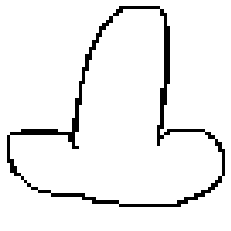

In [0]:
# visualize the first image
IMG_SIZE = 64
img_array = X_upright[0]
img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_array, cmap='gray')
plt.axis('off');

In [0]:
# shuffle data
df4 = df4.sample(frac=1, random_state=42)
df4 = df4.reset_index()
df4.head(5)

,index,countrycode,drawing,key_id,recognized,timestamp,word,drawing_np
0,2308,US,"[[[90, 40, 21, 5, 2, 0, 7, 40, 71, 117, 135, 1...",4872,True,2018-10-18 01:43:00.232000+00:00,penis,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
1,7759,ES,"[[[55, 64, 69, 84, 100, 110, 118, 118, 104, 10...",12574,True,2019-03-04 14:40:59.641000+00:00,penis,"[[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
2,5226,GB,"[[[255, 241, 226, 217, 199, 190, 178, 171, 150...",5291422213210112,True,2017-03-21 17:48:05.150490,arm,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
3,7047,BE,"[[[61, 91, 118, 146, 179, 229, 251, 255, 243, ...",11637,True,2018-11-23 11:04:20.827000+00:00,penis,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
4,2664,CA,"[[[0, 43, 88], [173, 124, 79]], [[88, 81, 83, ...",5307,True,2018-10-18 12:32:27.940000+00:00,penis,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


In [0]:
# label target
df4['target'] = [1 if x == 'penis' else 0 for x in df4['word']]
df4.head()

,index,countrycode,drawing,key_id,recognized,timestamp,word,drawing_np,target
0,2308,US,"[[[90, 40, 21, 5, 2, 0, 7, 40, 71, 117, 135, 1...",4872,True,2018-10-18 01:43:00.232000+00:00,penis,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1
1,7759,ES,"[[[55, 64, 69, 84, 100, 110, 118, 118, 104, 10...",12574,True,2019-03-04 14:40:59.641000+00:00,penis,"[[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1
2,5226,GB,"[[[255, 241, 226, 217, 199, 190, 178, 171, 150...",5291422213210112,True,2017-03-21 17:48:05.150490,arm,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0
3,7047,BE,"[[[61, 91, 118, 146, 179, 229, 251, 255, 243, ...",11637,True,2018-11-23 11:04:20.827000+00:00,penis,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1
4,2664,CA,"[[[0, 43, 88], [173, 124, 79]], [[88, 81, 83, ...",5307,True,2018-10-18 12:32:27.940000+00:00,penis,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1


In [0]:
# get data in right format
X = df4['drawing_np'].to_list()
X = np.array(X).reshape(-1, imheight, imwidth, 1)

In [0]:
# convert target to list
y = df4['target'].to_list()
y = np.array(y)

In [0]:
y[:20]

array([1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1])

In [0]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
len(X_train), len(X_test), len(y_train), len(y_test)

(23996, 6000, 23996, 6000)

In [0]:
# how many target variables are in the test set?
unique, counts = np.unique(y_test, return_counts=True)

table = np.asarray((unique, np.rint(counts))).T
print(table)

[[0.000e+00 3.997e+03]
 [1.000e+00 2.003e+03]]


In [0]:
X_train.shape

(23996, 64, 64, 1)

# 3. Train Model
The parameters of the model were chosen through trial and error and hyperparameter tuning.  

In [0]:
# convolutional neural network

model = Sequential()
model.add(Conv2D(64, (3,3), input_shape = X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))

model.add(Dense(1)) # change to number of classes
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        640       
_________________________________________________________________
activation (Activation)      (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 29, 29, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        7

In [0]:
# compile model
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [0]:
# fit model
model.fit(X_train, y_train, batch_size=20, epochs=10, validation_split=0.2)

Epoch 1/10
960/960 [==============================] - 15s 15ms/step - loss: 0.3203 - accuracy: 0.8589 - val_loss: 0.2097 - val_accuracy: 0.9179
Epoch 2/10
960/960 [==============================] - 14s 15ms/step - loss: 0.1696 - accuracy: 0.9333 - val_loss: 0.1494 - val_accuracy: 0.9429
Epoch 3/10
960/960 [==============================] - 14s 15ms/step - loss: 0.1285 - accuracy: 0.9502 - val_loss: 0.1463 - val_accuracy: 0.9417
Epoch 4/10
960/960 [==============================] - 14s 15ms/step - loss: 0.1023 - accuracy: 0.9604 - val_loss: 0.1243 - val_accuracy: 0.9508
Epoch 5/10
960/960 [==============================] - 14s 15ms/step - loss: 0.0812 - accuracy: 0.9688 - val_loss: 0.1082 - val_accuracy: 0.9588
Epoch 6/10
960/960 [==============================] - 14s 15ms/step - loss: 0.0642 - accuracy: 0.9758 - val_loss: 0.1243 - val_accuracy: 0.9610
Epoch 7/10
960/960 [==============================] - 14s 15ms/step - loss: 0.0504 - accuracy: 0.9821 - val_loss: 0.1590 - val_accuracy:

# 4. Test Model
The model works well (95% accuracy) on data similar to the training data.  The model had difficulty generalizing on hand drawn images.  The training images are drawn with a mouse on a plain white background.  The real world test data are pictures of images drawn on paper with different angles, shadows, brightness, backgrounds; lined paper, blank paper, colored paper etc.  Improvements were made by making test images look like the training images by removing the background, and connecting broken/dotted lines by making the lines thicker.  In our object detection notebook we tried to make the training data look more like the test data through creating our own dataset by drawing images and image augmentation.

In [0]:
# evaluate model on test data
print('\n# Evaluate on test data')
results = model.evaluate(X_test, y_test, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
47/47 [==============================] - 1s 21ms/step - loss: 0.1908 - accuracy: 0.9552
test loss, test acc: [0.19084306061267853, 0.9551666378974915]


In [0]:
# function that prints model predicts penis if prediction > .5
def show_pred(prediction):
    if prediction[0] > .5:
        print('Model predicts penis')
    else:
        print('Model predicts not penis')

[0.]
Model predicts not penis


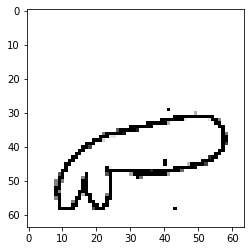

In [0]:
# test hand drawn images with model
def prepare(filepath):
    IMG_SIZE = 64
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    # denoise the background
    img_array = cv2.fastNlMeansDenoising(img_array, None, 10, 7, 21)
    # remove the background to make it look more like the training data
    img_array = cv2.adaptiveThreshold(img_array, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                      cv2.THRESH_BINARY,11,2)
    # make lines thicker with erosion to connect broken lines
    kernel = np.ones((8,8),np.uint8)
    img_array = cv2.erode(img_array, kernel, iterations=1)
    # resize
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    plt.imshow(new_array, cmap='gray')
    new_array = new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    return new_array

# change to path of image NOT in training data, like an actual drawing on paper
filepath = '/content/drive/My Drive/phallic-paper-background/IMG_2298.jpg'

prediction = model.predict([prepare(filepath)])

print(prediction[0])

show_pred(prediction)

True Positive: 21
False Negative: 17
Recall: 0.55%


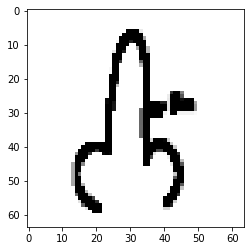

In [0]:
# iterates over files in test image directory to automate testing
# on phallic images only! - shows recall

# change directory to one containing images
directory = '/content/drive/My Drive/phallic-paper-background'

def prepare(filepath):
    IMG_SIZE = 64
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    # denoise the background
    img_array = cv2.fastNlMeansDenoising(img_array, None, 10, 7, 21)
    # remove the background to make it look more like the training data
    img_array = cv2.adaptiveThreshold(img_array, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                      cv2.THRESH_BINARY,11,2)
    # make lines thicker with erosion to connect broken lines
    kernel = np.ones((8,8),np.uint8)
    img_array = cv2.erode(img_array, kernel, iterations=1)
    # resize
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    plt.imshow(new_array, cmap='gray')
    new_array = new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    return new_array

pred_list = []

for filename in os.listdir(directory):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        filepath = directory + '/' + filename
        prediction = model.predict([prepare(filepath)])
        pred_list.append(np.rint(prediction[0]))
    else:
        pass
    
tp = pred_list.count(1)
fn = pred_list.count(0)

recall = tp / (tp + fn)
recall = round(recall, 2)

print('True Positive:', tp)
print('False Negative:', fn)
print('Recall:', str(recall) + '%')

False Positive: 4
True Negative: 29
Specificity 0.88%


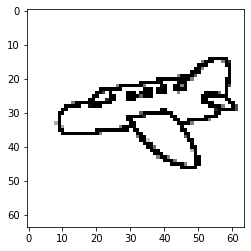

In [0]:
# iterates over files in test image directory to automate testing
# on non-phallic images only! shows specificity

# change directory to one containing images
directory = '/content/drive/My Drive/non-phallic'

def prepare(filepath):
    IMG_SIZE = 64
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    # denoise the background
    img_array = cv2.fastNlMeansDenoising(img_array, None, 10, 7, 21)
    # remove the background to make it look more like the training data
    img_array = cv2.adaptiveThreshold(img_array, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                      cv2.THRESH_BINARY,11,2)
    # make lines thicker with erosion to connect broken lines
    kernel = np.ones((8,8),np.uint8)
    img_array = cv2.erode(img_array, kernel, iterations=1)
    # resize
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    plt.imshow(new_array, cmap='gray')
    new_array = new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    return new_array

pred_list = []

for filename in os.listdir(directory):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        filepath = directory + '/' + filename
        prediction = model.predict([prepare(filepath)])
        pred_list.append(np.rint(prediction[0]))
    else:
        pass

fp = pred_list.count(1)
tn = pred_list.count(0)

specificity =  tn / (tn + fp)
specificity = round(specificity, 2)

print('False Positive:', fp)
print('True Negative:', tn)
print('Specificity', str(specificity) + '%')

In [0]:
# accuracy calculation for all drawings 
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy = round(accuracy, 2)
print('Accuracy:', str(accuracy) + '%')

Accuracy: 0.7%


In [0]:
# save model for later use
model.save('/content/drive/My Drive/64x64-Airplane-Arm-70.model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/64x64-Airplane-Arm-70.model/assets
